### Bank Marketing Data from Kaggle: Implementing and Experimenting with Artificial Neural Network

### About the Problem: 
### Objective is to find the best strategies to improve for the next marketing campaign. How can the financial institution have a greater effectiveness for future marketing campaigns? In order to answer this, we have to analyze the last marketing campaign the bank performed and identify the patterns that will help us find conclusions in order to develop future strategies.


### Importing Libraries

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

### Reading the 'bank' Dataset

In [2]:
df_Bank=pd.read_csv('bank-full.csv',sep=';')
df_Bank.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [3]:
df_Bank.shape

(45211, 17)

### Exploratory Data Analysis:

In [4]:
#Check for Missing Value

df_Bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [5]:
df_Bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Correlation plot to pick out the best features for the model

Text(0.5,1,'Heatmap of Variables')

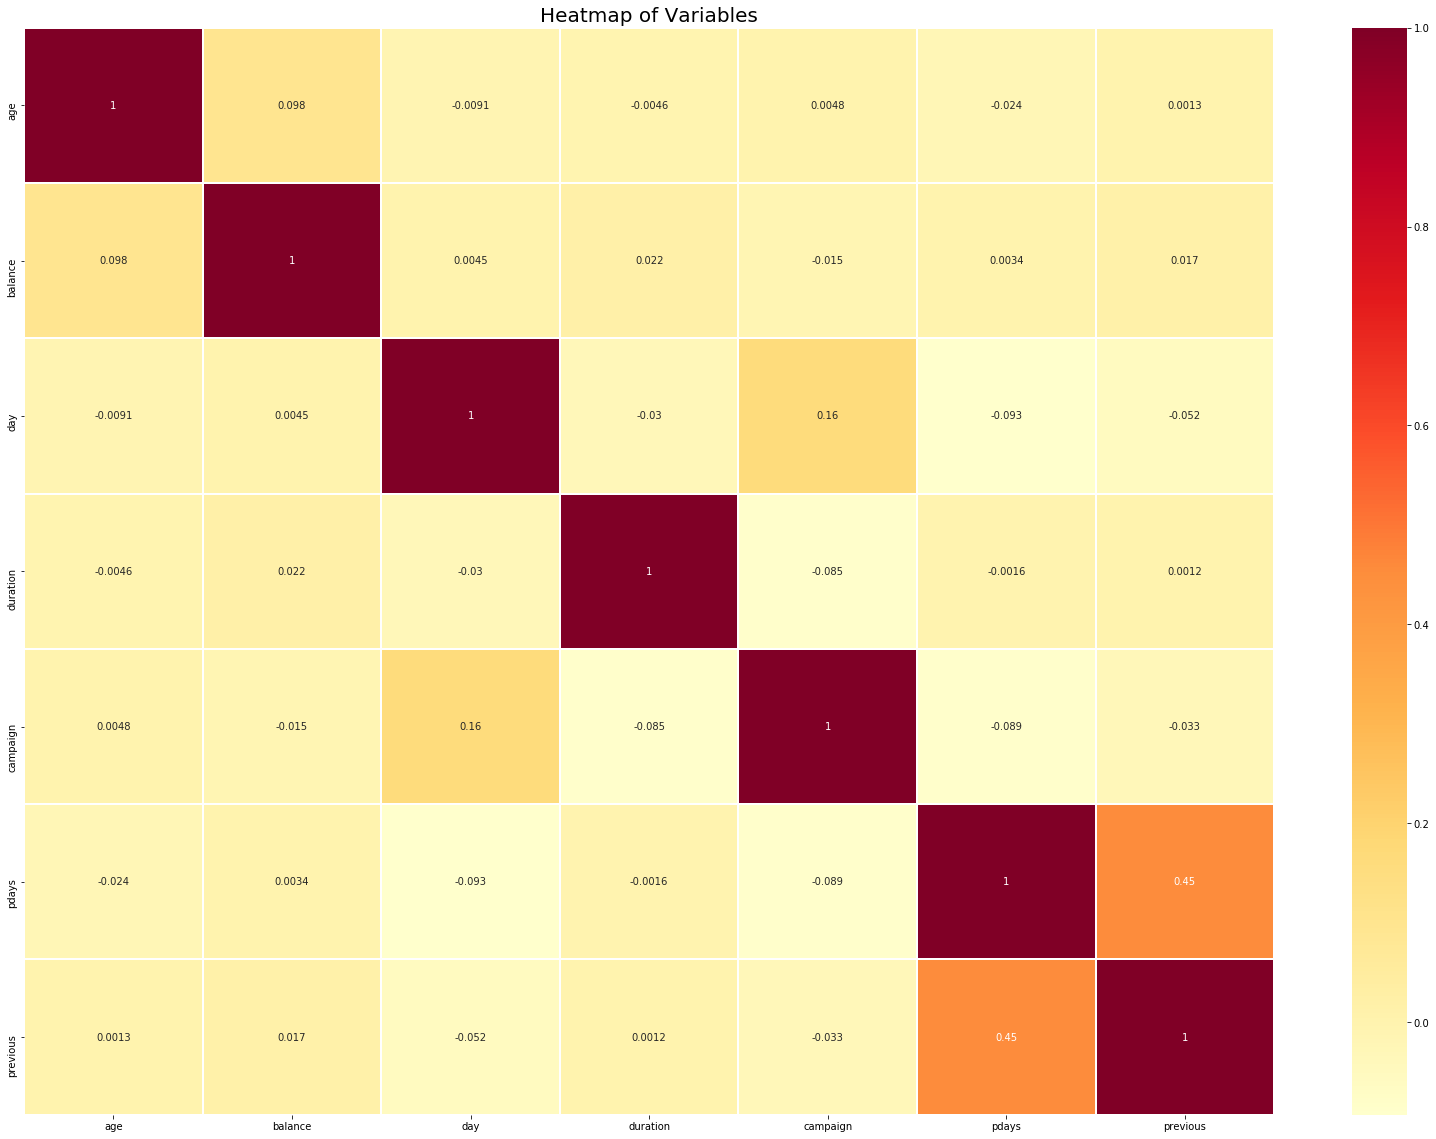

In [6]:
#Correlation:

fig = plt.figure(figsize=(28,20))

axis = sns.heatmap(df_Bank.corr(), cmap= 'YlOrRd', linewidth=1, linecolor='white', annot=True)
axis.set_title('Heatmap of Variables', fontsize=20)

### For the feature selection we are implementing the elimination using correlation backed up by the business intuition-

In [7]:
corr_matrix = df_Bank.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol = sol.to_frame()
sol.columns=['corr']
sol[sol['corr'] >  0.88]

,,corr


In [8]:
df_Bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [9]:
cat=["job", "marital", "education","contact","month", "poutcome"]

### Data Preparation:

### Label Encoding for the above categorical features-

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in cat:
    print("Encoding",i)
    df_Bank[i] = le.fit_transform(df_Bank[i])

Encoding job
Encoding marital
Encoding education
Encoding contact
Encoding month
Encoding poutcome


In [11]:
cleanup_nums = {"default":     {"yes": 1, "no": 0},
                "housing": {"yes": 1, "no": 0}, "loan":{"yes": 1, "no": 0}, "y":{"yes": 1, "no": 0}}

In [12]:
df_Bank.replace(cleanup_nums, inplace=True)

In [13]:
df_Bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

### Encoded data looks like this: 

In [14]:
df_Bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


### Lets have a overlook at the count of classes to check the Ratio of Classes: 

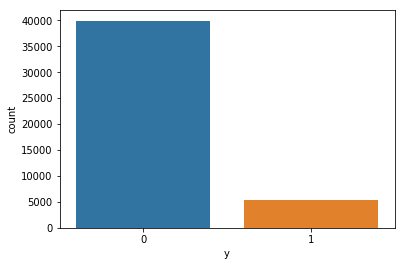

In [15]:
sns.countplot(df_Bank['y'])

### Its a clear case of "Class Imbalance Problem"-
### Here the 'Class 0' which shows that "Client is not Subscribing a term deposit" accounts for more than 90% of the data and ' Class 1' accounts for merely 10%. But my objecive here is to identify the instances of 'Class 1'. I can reach an accuracy of around 90% by simply predicting 'Class 0' every time, but this provides a useless classifier for my intended use case. 

### Due to this reason,  I will 'undersample' the instances of majority class (i.e 'Class 0'). This way I will simply create a balanced data-set. 

### *Undersampling* data

In [16]:
yes = len(df_Bank[df_Bank["y"]==1])
yes

5289

In [17]:
# Index of normal classes
no=df_Bank[df_Bank["y"]==0].index

# Random sample non-fraud indexes
no_ind=np.random.choice(no,yes,replace=False)

# Index of fraud classes
yes_ind=df_Bank[df_Bank.y==1].index

# Concat fraud indexes and sample normal indexes
final_ind=np.concatenate([no_ind,yes_ind])

# Final balanced dataframe from undersampling
balanced_df=df_Bank.loc[final_ind]

balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10578 entries, 33007 to 45208
Data columns (total 17 columns):
age          10578 non-null int64
job          10578 non-null int64
marital      10578 non-null int64
education    10578 non-null int64
default      10578 non-null int64
balance      10578 non-null int64
housing      10578 non-null int64
loan         10578 non-null int64
contact      10578 non-null int64
day          10578 non-null int64
month        10578 non-null int64
duration     10578 non-null int64
campaign     10578 non-null int64
pdays        10578 non-null int64
previous     10578 non-null int64
poutcome     10578 non-null int64
y            10578 non-null int64
dtypes: int64(17)
memory usage: 1.5 MB


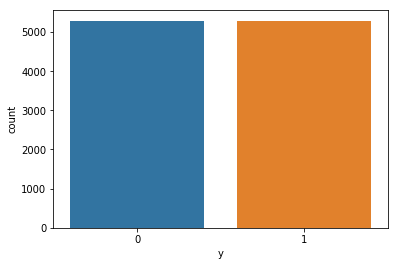

In [18]:
sns.countplot(balanced_df['y'])

### Shape of new balanced data-set after Undersampling:

In [19]:
balanced_df.shape

(10578, 17)

### Train Test Split: Splitting the data into Train and Test sets and scaling the data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = balanced_df.drop(columns=['y'],axis=1)
y = balanced_df['y']

xTrain_org, xTest_org, yTrain, yTest = train_test_split(x,y, test_size = 0.3, random_state = 0)

scaler = StandardScaler()

xTrain = scaler.fit_transform(xTrain_org)
xTest = scaler.transform(xTest_org)

In [21]:
print('Shape of xTrain Set', xTrain.shape)
print('Shape of yTrain Set', yTrain.shape)

print('')

print('Shape of xTest Set', xTest.shape)
print('Shape of yTest Set', yTest.shape)

Shape of xTrain Set (7404, 16)
Shape of yTrain Set (7404,)

Shape of xTest Set (3174, 16)
Shape of yTest Set (3174,)


### Importing libraries for Neural Network and Grid Search

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

### 1) Creating a basic Neural Network model with just Input and Output Layer


In [23]:
### Number of neurons in input layer = Number of features + 1(for bias)

model = Sequential()
model.add(Dense(17, input_dim = 16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(xTrain,yTrain)

Epoch 1/1
7404/7404 [==============================] - 0s 47us/step - loss: 0.6175 - acc: 0.6507


In [24]:
model.evaluate(xTrain,yTrain)

7404/7404 [==============================] - 0s 12us/step


[0.5313108413687015, 0.748784440874989]

In [25]:
model.evaluate(xTest,yTest)

3174/3174 [==============================] - 0s 10us/step


[0.536472662973494, 0.7309388784244516]

### Confusion Metrics:

In [26]:
y_test_pred = model.predict(xTest)

y_pred = np.where(y_test_pred>= 0.5, 1, 0)

print('Classification Report:')
print(classification_report(yTest,y_pred))
print('Confusion Matrix:')
print(confusion_matrix(yTest,y_pred))

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.72      0.72      1568
          1       0.73      0.74      0.74      1606

avg / total       0.73      0.73      0.73      3174

Confusion Matrix:
[[1124  444]
 [ 410 1196]]


### ---Experimenting with different Parameters (showing various Learning Curves also for better understanding)---

### 2a) Batch Size: Variation of Accuracy by Batch Size

3174/3174 [==============================] - 0s 10us/step


Text(0,0.5,'Accuracy')

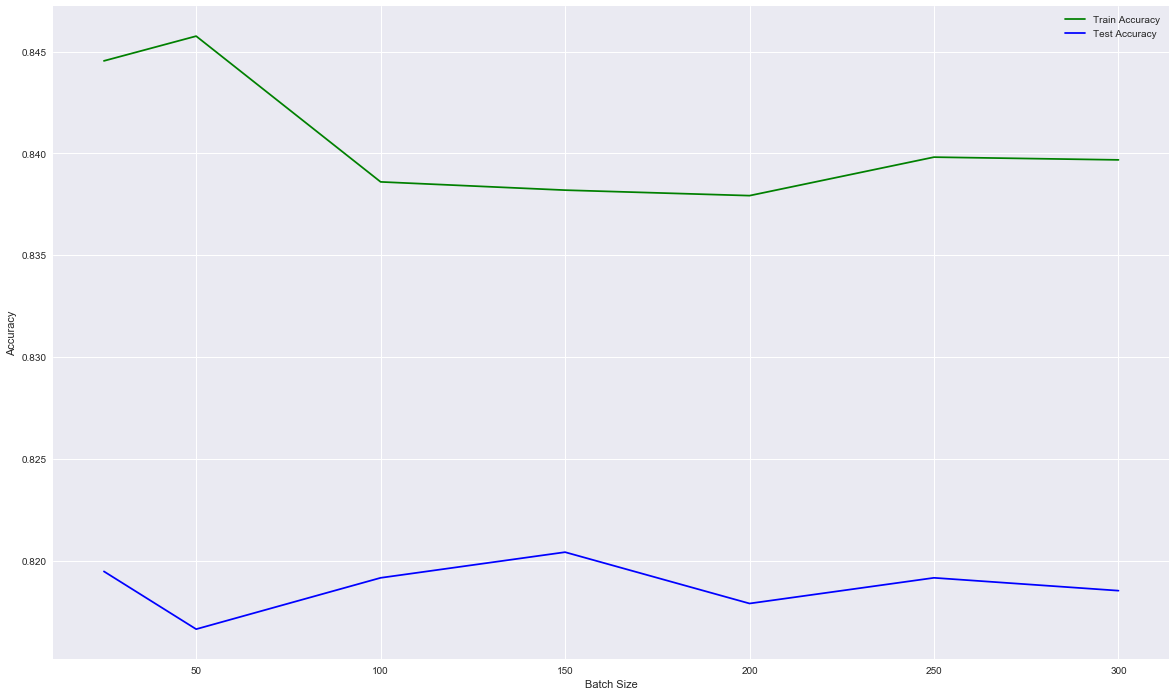

In [27]:
sns.set(rc={'figure.figsize':(20,12)})

batch_size = [25,50,100,150,200,250,300]

train_accuracy_array = []
test_accuracy_array = []

for i in batch_size:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    
    model.fit(xTrain, yTrain, epochs=150, batch_size = i, verbose=0)
    
    train_accuracy_array.append(model.evaluate(xTrain, yTrain)[1])
    test_accuracy_array.append(model.evaluate(xTest, yTest)[1])

    
x_axis = [25,50,100,150,200,250,300]
plt.plot(x_axis, train_accuracy_array, c = 'g', label = 'Train Accuracy')
plt.plot(x_axis, test_accuracy_array, c = 'b', label = 'Test Accuracy')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')

### 2b) Variation of Loss by Batch Size:

3174/3174 [==============================] - 0s 12us/step


Text(0,0.5,'Loss')

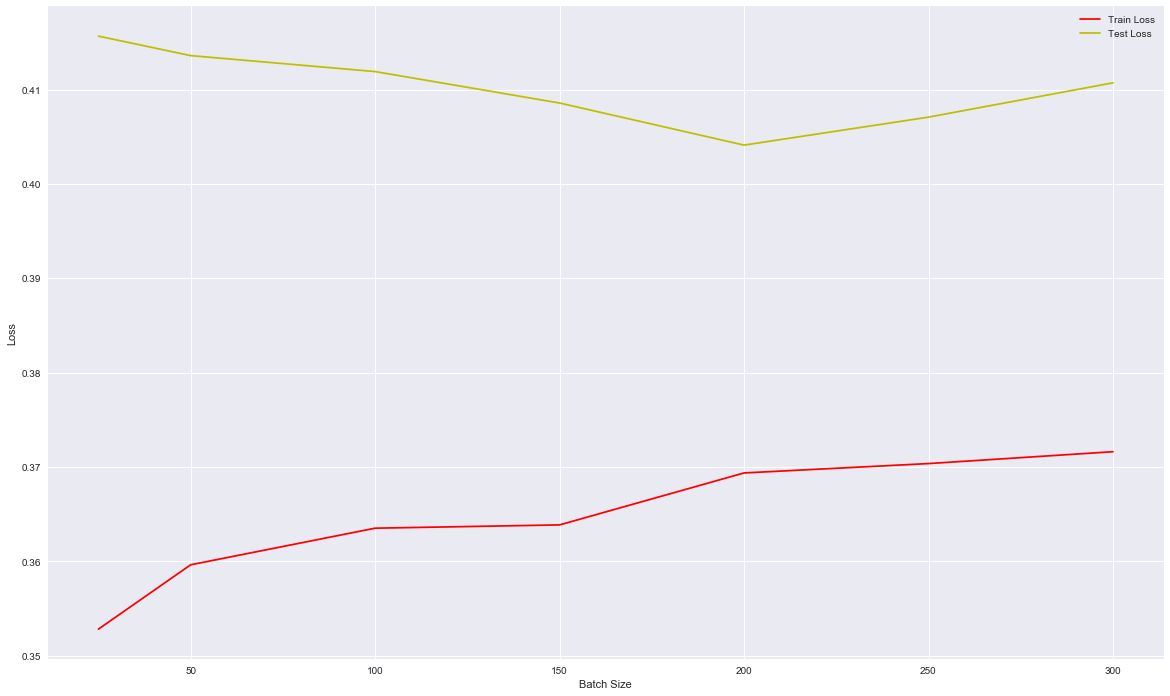

In [28]:
sns.set(rc={'figure.figsize':(20,12)})

batch_size = [25,50,100,150,200,250,300]

train_loss_array =[]
test_loss_array =[]

for i in batch_size:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=150,batch_size=i,verbose=0)
    
    train_loss_array.append(model.evaluate(xTrain, yTrain)[0])
    test_loss_array.append(model.evaluate(xTest, yTest)[0])
    
x_axis = [25,50,100,150,200,250,300]
plt.plot(x_axis, train_loss_array, c = 'r', label = 'Train Loss')
plt.plot(x_axis, test_loss_array, c = 'y', label = 'Test Loss')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Loss')

### Above experiment shows that for the "batch_size = 150" both Loss  is less and Accuracy are optimal

### 3a) Epochs: Variation of Accuracy by Epochs

3174/3174 [==============================] - 0s 18us/step


Text(0,0.5,'Accuracy')

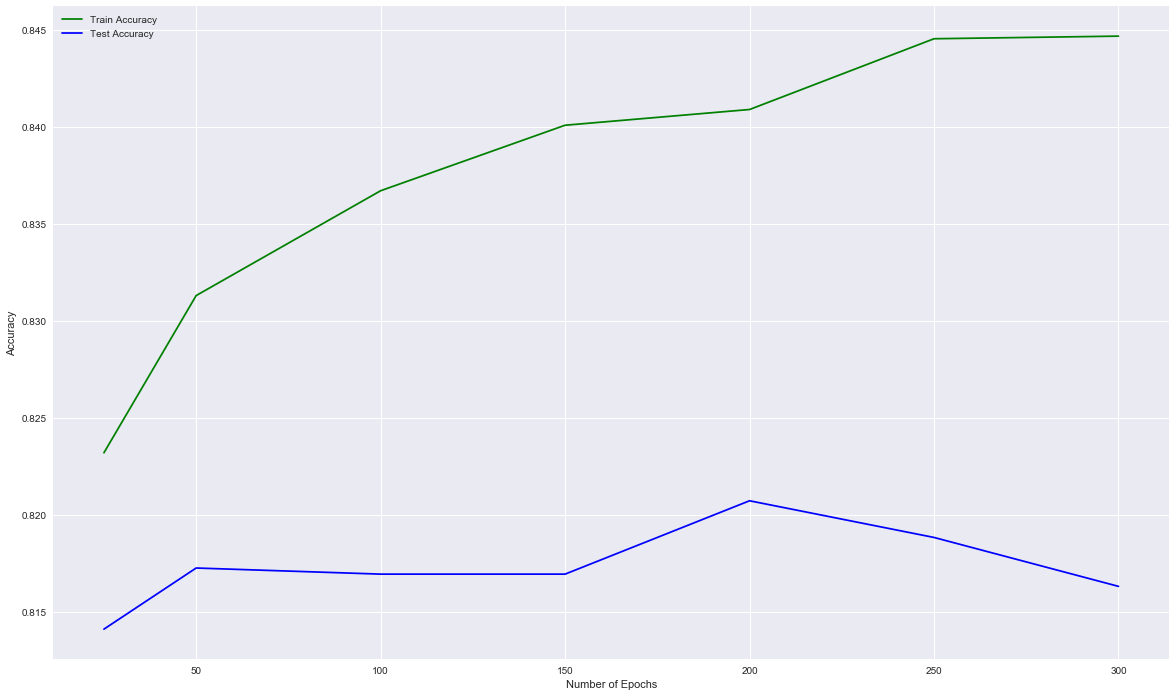

In [39]:
sns.set(rc={'figure.figsize':(20,12)})

epochs = [25,50,100,150,200,250,300]

train_accuracy_array = []
test_accuracy_array = []

for i in epochs:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=i,batch_size=150,verbose=0)                                    #batch size=150
    
    train_accuracy_array.append(model.evaluate(xTrain, yTrain)[1])
    test_accuracy_array.append(model.evaluate(xTest, yTest)[1])

    
x_axis = [25,50,100,150,200,250,300]
plt.plot(x_axis, train_accuracy_array, c = 'g', label = 'Train Accuracy')
plt.plot(x_axis, test_accuracy_array, c = 'b', label = 'Test Accuracy')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

### 3b) Variation of Loss by Epochs

3174/3174 [==============================] - 0s 29us/step


Text(0,0.5,'Loss')

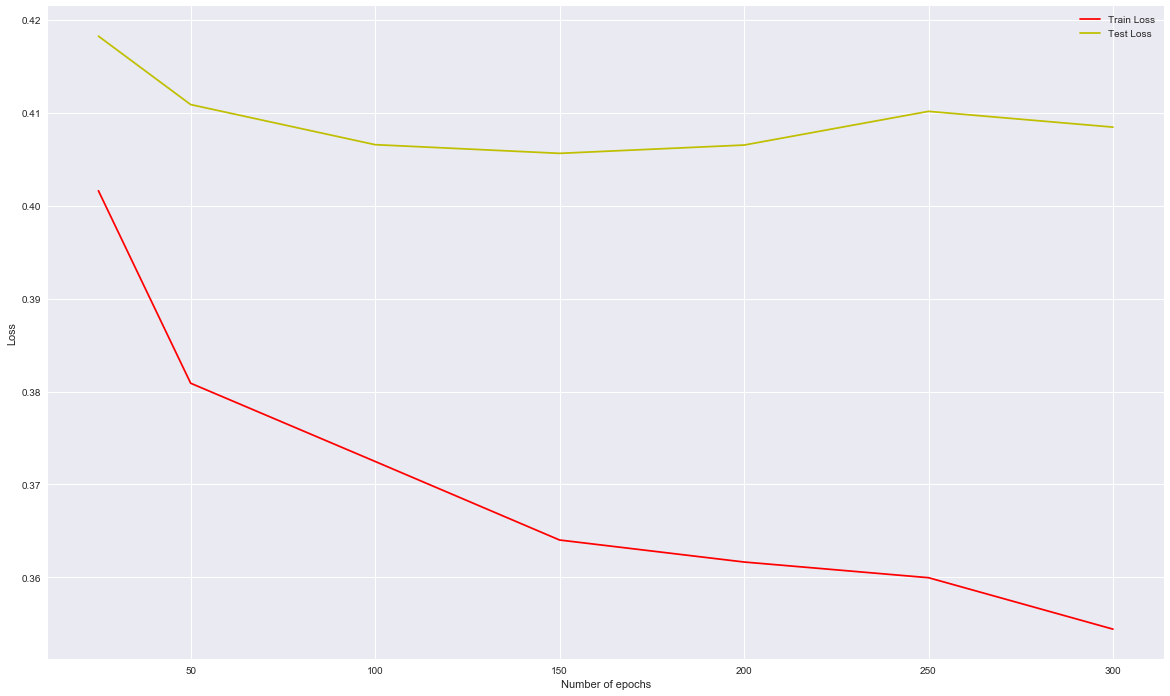

In [40]:
sns.set(rc={'figure.figsize':(20,12)})

epochs = [25,50,100,150,200,250,300]

train_loss_array =[]
test_loss_array =[]

for i in batch_size:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=i,batch_size=150,verbose=0)                                 #batch size = 150
    
    train_loss_array.append(model.evaluate(xTrain, yTrain)[0])
    test_loss_array.append(model.evaluate(xTest, yTest)[0])
    
x_axis = [25,50,100,150,200,250,300]
plt.plot(x_axis, train_loss_array, c = 'r', label = 'Train Loss')
plt.plot(x_axis, test_loss_array, c = 'y', label = 'Test Loss')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

### Above experiment shows that from epoch 150 to 200 Test Accuracy shows the incremental trend at  "epoch = 200" it has highest value, similarly with 200 epochs value of loss is also low. So I will choose 200 Epochs for my experiment.

### 4a) Optimizer: Variation of Accuracy by Optimizer

3174/3174 [==============================] - 0s 21us/step


Text(0,0.5,'Accuracy')

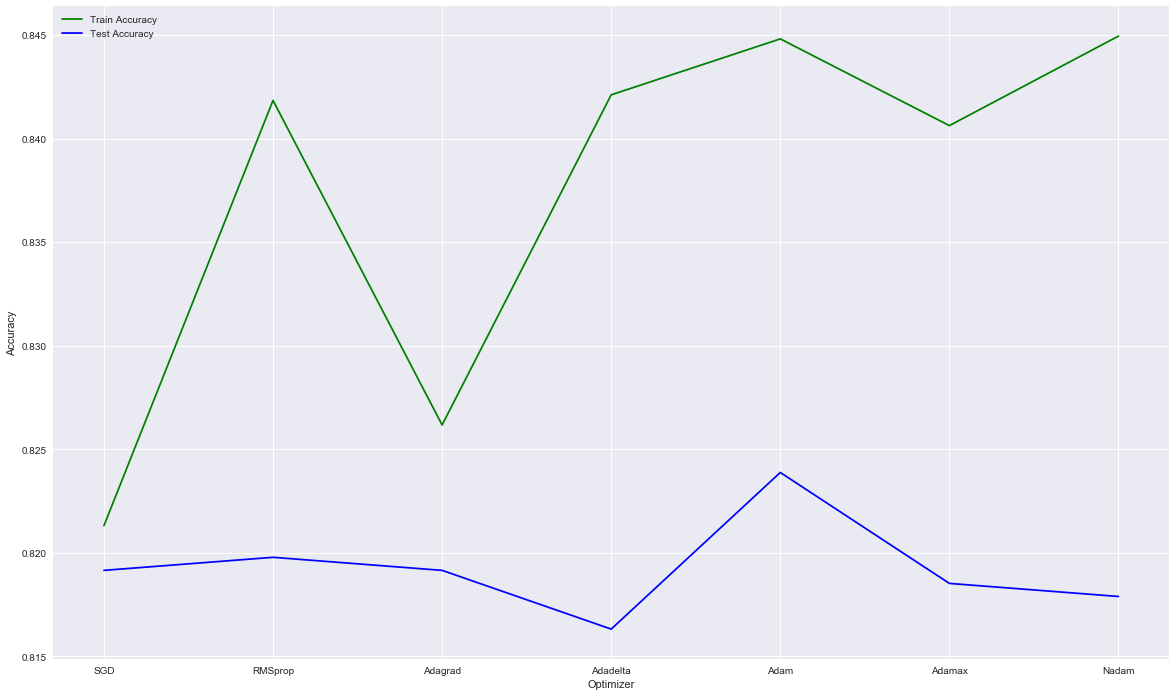

In [41]:
sns.set(rc={'figure.figsize':(20,12)})

optimizer =['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

train_accuracy_array = []
test_accuracy_array = []

for i in optimizer:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = i, metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=200,batch_size=150,verbose=0)                              # batch size = 150, epochs=200
    
    train_accuracy_array.append(model.evaluate(xTrain, yTrain)[1])
    test_accuracy_array.append(model.evaluate(xTest, yTest)[1])

    
x_axis = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
plt.plot(x_axis, train_accuracy_array, c = 'g', label = 'Train Accuracy')
plt.plot(x_axis, test_accuracy_array, c = 'b', label = 'Test Accuracy')
plt.legend()
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

### 4b) Variation of Loss by Optimizer

3174/3174 [==============================] - 0s 22us/step


Text(0,0.5,'Loss')

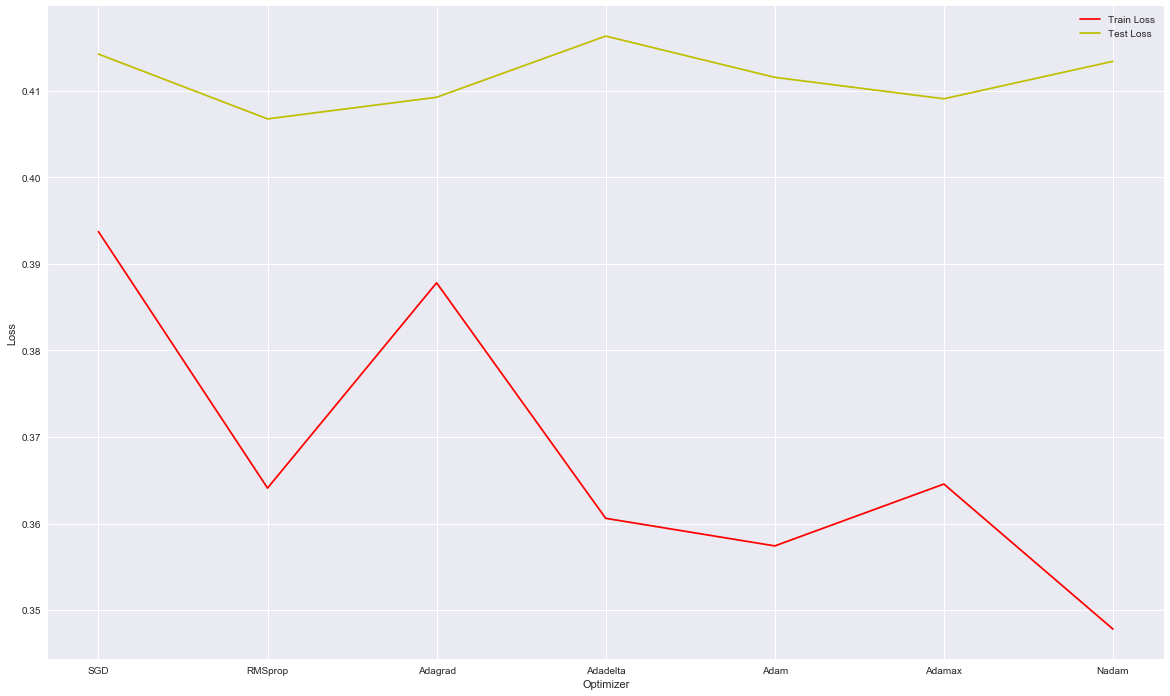

In [42]:
sns.set(rc={'figure.figsize':(20,12)})

optimizer =['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

train_loss_array =[]
test_loss_array =[]

for i in optimizer:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = i, metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=200,batch_size=150,verbose=0)                         # batch size = 150, epochs=200
    
    train_loss_array.append(model.evaluate(xTrain, yTrain)[0])
    test_loss_array.append(model.evaluate(xTest, yTest)[0])
    
x_axis = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
plt.plot(x_axis, train_loss_array, c = 'r', label = 'Train Loss')
plt.plot(x_axis, test_loss_array, c = 'y', label = 'Test Loss')
plt.legend()
plt.xlabel('Optimizer')
plt.ylabel('Loss')

### Above experiment for Optimizer shows that for "Adam", Train and Test accuracy is high and loss is also low

### 5a) Input Activation Function: Variation of Accuracy by input activation function:

3174/3174 [==============================] - 0s 24us/step


Text(0,0.5,'Accuracy')

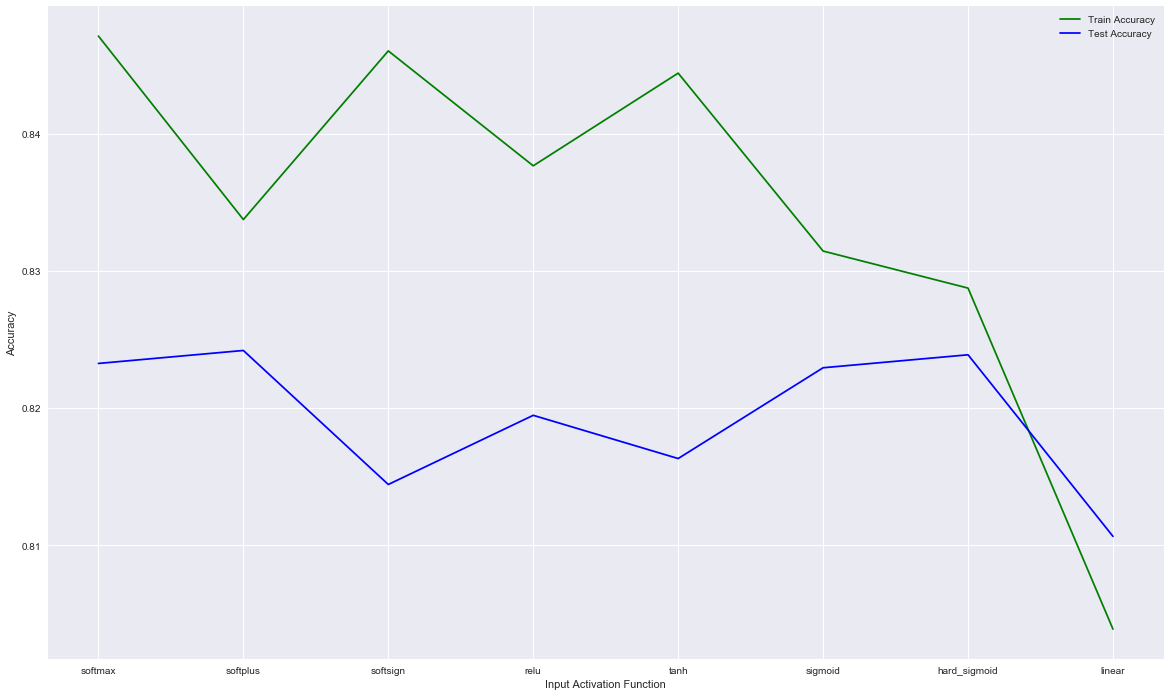

In [43]:
sns.set(rc={'figure.figsize':(20,12)})

activations = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

train_accuracy_array = []
test_accuracy_array = []

for i in activations:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = i))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=200,batch_size=150,verbose=0)          
                                                                                 # batch size=150, epochs=200, Optimizer=Adam
    
    train_accuracy_array.append(model.evaluate(xTrain, yTrain)[1])
    test_accuracy_array.append(model.evaluate(xTest, yTest)[1])

    
x_axis = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
plt.plot(x_axis, train_accuracy_array, c = 'g', label = 'Train Accuracy')
plt.plot(x_axis, test_accuracy_array, c = 'b', label = 'Test Accuracy')
plt.legend()
plt.xlabel('Input Activation Function')
plt.ylabel('Accuracy')

### 5b) Variation of Loss by input activation function:

3174/3174 [==============================] - 0s 25us/step


Text(0,0.5,'Loss')

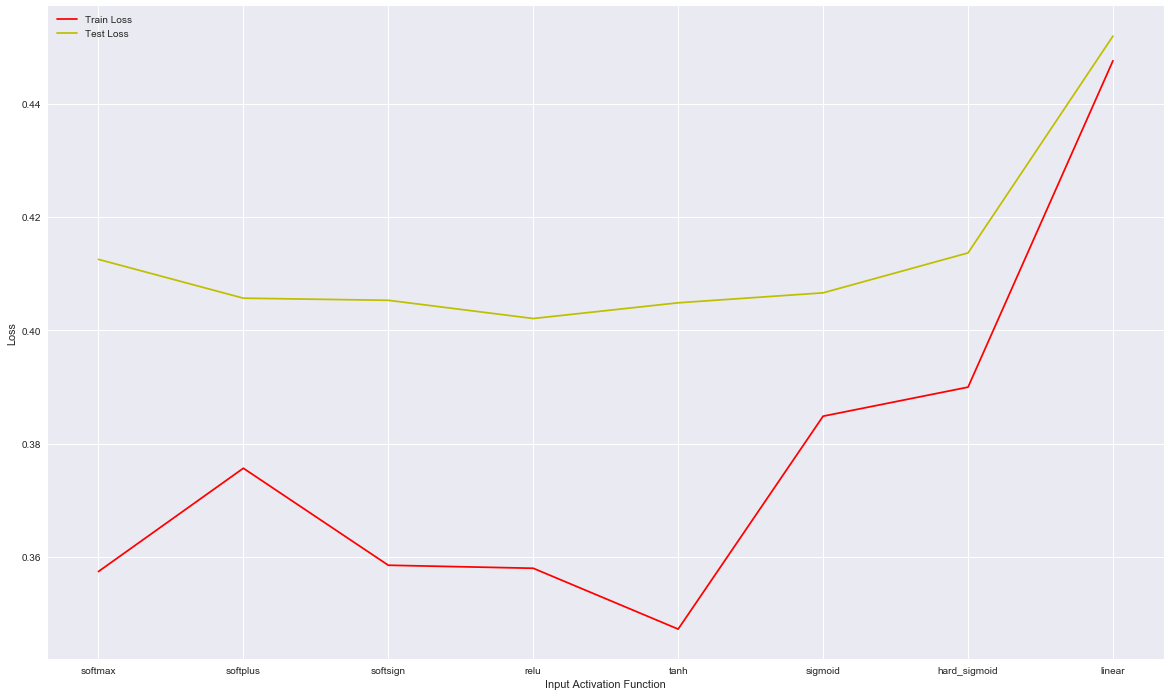

In [44]:
sns.set(rc={'figure.figsize':(20,12)})

activations = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

train_loss_array =[]
test_loss_array =[]

for i in activations:
    model = Sequential()
    model.add(Dense(17, input_dim = 16, activation = i))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    model.fit(xTrain,yTrain,epochs=200,batch_size=150,verbose=0)                 
                                                                                 # batch size=150, epochs=200, Optimizer=Adam
    
    train_loss_array.append(model.evaluate(xTrain, yTrain)[0])
    test_loss_array.append(model.evaluate(xTest, yTest)[0])
    
x_axis = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
plt.plot(x_axis, train_loss_array, c = 'r', label = 'Train Loss')
plt.plot(x_axis, test_loss_array, c = 'y', label = 'Test Loss')
plt.legend()
plt.xlabel('Input Activation Function')
plt.ylabel('Loss')

### So its clear from the above experiment that for "softplus" input activation function Accuracy is high and Loss is low

### Summary of above Experiments:

### From all of the above experiments we got the following best parameters-
### 1. batch_size = 150
### 2. Epochs = 200
### 3. Optimizer = Adam
### 4. Activation Function = softplus

### Apply above parameters on the basic Neural Network (with only i/p and o/p layer):

In [45]:
model = Sequential()
model.add(Dense(17, input_dim = 16, activation = 'softplus'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(xTrain,yTrain,epochs=200,batch_size=150,verbose=0)

In [46]:
model.evaluate(xTrain, yTrain)

7404/7404 [==============================] - 1s 190us/step


[0.377869840693242, 0.8326580227226389]

In [47]:
model.evaluate(xTest, yTest)

3174/3174 [==============================] - 0s 31us/step


[0.40501939909557316, 0.8204158790170132]

In [64]:
y_test_pred = model.predict(xTest)
y_pred = np.where(y_test_pred>= 0.5, 1, 0)

print('Classification Report:')
print(classification_report(yTest,y_pred))
print('Confusion Matrix:')
print(confusion_matrix(yTest,y_pred))

Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.82      0.82      1568
          1       0.82      0.83      0.83      1606

avg / total       0.82      0.82      0.82      3174

Confusion Matrix:
[[1280  288]
 [ 274 1332]]


### Observation: These values of Train and Test Accuracies (and loss) are clearly better than the previous NN model that we trained and test at the very beginning (where loss was around 0.52 and accuracy was around 0.71)
### Based upon our observation of various learning curves, these experiments helped us to find the good parameters.

## Additional Experiments:

### 6) Adding a Hidden Layer to see if Accuracy is improved:

In [61]:
model = Sequential()
model.add(Dense(17, input_dim = 16, activation = 'softplus'))
model.add(Dense(9, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(xTrain,yTrain,epochs=200,batch_size=150,verbose=0)

In [62]:
model.evaluate(xTrain, yTrain)

7404/7404 [==============================] - ETA:  - 2s 220us/step


[0.3562574301343683, 0.8423824959803374]

In [63]:
model.evaluate(xTest, yTest)

3174/3174 [==============================] - 0s 28us/step


[0.40938626616611073, 0.8229363579080026]

In [65]:
y_test_pred = model.predict(xTest)
y_pred = np.where(y_test_pred>= 0.5, 1, 0)

print('Classification Report:')
print(classification_report(yTest,y_pred))
print('Confusion Matrix:')
print(confusion_matrix(yTest,y_pred))

Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.82      0.82      1568
          1       0.82      0.83      0.83      1606

avg / total       0.82      0.82      0.82      3174

Confusion Matrix:
[[1280  288]
 [ 274 1332]]


### Result: 

### A Term deposit is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time.

### Solution for next Marketing Campaign-
### Banks should more focused on campaigns and customers with higher education, moreover, there should be some additional campaigning activities for the other cohort of users. A Questionaire or feedback forms can also be implemented in practice to understand the customer's views. Seasonality also plays a critical role here. Previous credit history of cleints can also be another deciding factor.

